In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tqdm import tqdm
import os
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
###................................Functions................................###
def getNeighborsTemperature(grid, point, T_inf,B):
    neighbors = []
    
    rows = len(grid)
    cols = len(grid[0])

    for i in range(-1,2):
        for j in range(-1,2):
            try:
                if abs(i) != abs(j):
                    neighbors.append(grid[point[0] + i][point[1]+ j])
            except IndexError:
                
                ###...Edge or corner point...###
                # Upper edge point:
                if point[0] == 0:
                    # upper left corner point
                    if point[1] == 0:
                        if i==-1 and j==0:
                            boundary_temp = grid[point[0] + 1][point[1]] + B*(T_inf-grid[point[0]][point[1]]) # i!=0
                            neighbors.append(boundary_temp)
                        elif i==0 and j==1:
                            boundary_temp = grid[point[0]][point[1]-1] + B*(T_inf-grid[point[0]][point[1]]) # j!=0
                            neighbors.append(boundary_temp)
                    # upper right corner point
                    elif point[1] == cols - 1:
                        if i==1 and j==0:
                            boundary_temp = grid[point[0]-1][point[1]] + B*(T_inf - grid[point[0]][point[1]]) # i!=0
                            neighbors.append(boundary_temp)
                        elif i==0 and j==1:
                            boundary_temp = grid[point[0]][point[1]-1] + B*(T_inf - grid[point[0]][point[1]]) # j!=0
                            neighbors.append(boundary_temp)
                    # upper edge
                    else:
                        boundary_temp = grid[point[0]][point[1]-1] + B*(T_inf - grid[point[0]][point[1]] )
                        neighbors.append(boundary_temp)
                
                # lower edge point
                elif point[0] == rows - 1:
                    # Lower left corner
                    if point[1] == 0:
                        if i==-1 and j==0:
                            boundary_temp = grid[point[0]+1][point[1]] + B*(T_inf - grid[point[0]][point[1]]) # i!=0
                            neighbors.append(boundary_temp)
                        elif i==0 and j==-1:
                            boundary_temp = grid[point[0]][point[1]+1] + B*(T_inf - grid[point[0]][point[1]]) # j!=0
                            neighbors.append(boundary_temp)
                    
                    # lower right corner
                    elif point[1] == cols - 1:
                        if i==1 and j==0:
                            boundary_temp = grid[point[0]-1][point[1]] + B*(T_inf - grid[point[0]][point[1]]) # i!=0
                            neighbors.append(boundary_temp)
                        elif i==0 and j==-1:
                            boundary_temp = grid[point[0]][point[1]+1] + B*(T_inf - grid[point[0]][point[1]]) # j!=0
                            neighbors.append(boundary_temp)
                    
                    # lower edge
                    else:
                        boundary_temp = grid[point[0]][point[1]+1] + B*(T_inf - grid[point[0]][point[1]]) # j!=0
                        neighbors.append(boundary_temp)
                
                # left edge
                elif point[1] == 0:
                    boundary_temp = grid[point[0]+1][point[1]] + B*(T_inf - grid[point[0]][point[1]]) # i!=0
                    neighbors.append(boundary_temp)
                
                # right edge
                elif point[1] == cols - 1:
                    boundary_temp = grid[point[0]-1][point[1]] + B*(T_inf - grid[point[0]][point[1]]) # i!=0
                    neighbors.append(boundary_temp)
                
                neighbors.append(T_inf)

    return neighbors
 
def calculateHeat(cellTemp, neighborTemps, gamma):
    cellTemp = cellTemp + gamma*((neighborTemps[0] -2*cellTemp + neighborTemps[-1]) + (neighborTemps[1] -2*cellTemp + neighborTemps[-2]))
    #print(cellTemp)
    return np.float64(cellTemp)

def heatTransfer(grid, boundaryTemp, B_i):
    for i in range(0,len(grid)):
        for j in range(0,len(grid)):
            neighbors = getNeighborsTemperature(grid[:,:,0], (i,j), boundaryTemp, B_i)
            grid[:,:,0][i][j] = calculateHeat(grid[:,:,0][i][j], neighbors, grid[:,:,1][i][j])
    return grid

def calculateAverageTemperatureWithinCircle(grid, center, radius):
    # Extract the temperature values from the grid
    temperatures = grid[:, :, 0]

    # Create a mask for the circle
    x, y = np.indices(temperatures.shape)
    mask = ((x - center[0])**2 + (y - center[1])**2) <= radius**2

    # Calculate the average temperature within the circle
    average_temperature = np.mean(temperatures[mask])
    
    return average_temperature

def diameter_heat_simulation(startingTemperature, boundaryTemp, temp_value_to_add, timeStep, number_of_time_steps, resolution, center, heat_radius, rad_of_interest, gamma, B_i):
    
    #Configure the grid
    x1 = np.full(resolution, startingTemperature)
    y1 = np.full(resolution, startingTemperature)

    x2 = np.full(resolution, gamma)
    y2 = np.full(resolution, gamma)

    gridX, gridY = np.meshgrid(x1,y1)
    gridX2, gridY2 = np.meshgrid(x2,y2)

    fullGridX = np.dstack([gridX,gridX2])
    #fullGridY = np.dstack([gridY,gridY2]) # Because of symmetry not necessary

    # create meshgrid coordinates
    x = np.arange(resolution)
    y = np.arange(resolution)
    # create meshgrid for the x,y coordinates
    X, Y = np.meshgrid(x, y)
    # Berechne den Abstand jedes Gitterpunkts zum Mittelpunkt
    distances = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    # Überprüfe, ob der Abstand kleiner oder gleich dem Radius ist
    mask = distances <= heat_radius
    # Aktualisiere die Werte im Gitter entsprechend der Maske
    fullGridX[:,:,0][mask] += temp_value_to_add

    # Plot the created mask
    white_image = Image.new('L', (resolution, resolution), 255)
    white_image = white_image * mask
    plt.imshow(white_image,cmap='gray')
    plt.show()

    #Run simulation
    frames = [fullGridX[:,:,0].copy()]
    temp_array = [calculateAverageTemperatureWithinCircle(fullGridX, center, rad_of_interest)]

    for t in tqdm(range(0,number_of_time_steps)):
            # Calculate the heat
            fullGridX = heatTransfer(fullGridX.copy(),boundaryTemp, B_i)
            frames.append(fullGridX[:,:,0].copy())

            # Calculate the average temperature within the circle and append to the list
            average_temp_in_circle = calculateAverageTemperatureWithinCircle(fullGridX, center, rad_of_interest)
            temp_array.append(average_temp_in_circle)
    
    # Calculate the time step vector
    specific_point = timeStep*number_of_time_steps
    step_size = timeStep
    time_step_array =  np.arange(0, specific_point, step_size)
    time_step_array = [element * 100 for element in time_step_array] # times 100 to transform it into nano seconds (10^-9 *100 = 10^-7)
    
    return time_step_array, temp_array, frames

def makeGif(frames,name,time_step_array,minTemp,maxTemp, frames_name):
    images = []
    for i in tqdm(range(0,len(frames))):
            plt.figure()
            plt.title(f"Temperature at t = {time_step_array[i]} unit time")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.pcolormesh(frames[i], cmap="inferno", vmin=minTemp, vmax=maxTemp)
            plt.colorbar()
            plt.savefig(f"temp_frame_{i}.png")
            plt.close()
            
            images.append(imageio.imread(f"temp_frame_{i}.png"))
            
    imageio.mimsave(name+ ".gif", images, cmap="inferno")

    for i in range(len(frames)):
        os.remove(f"temp_frame_{i}.png")

def twoD_gauss_distribution(x, y, mu_x, mu_y, sigma_x, sigma_y):

    # Calculate a unnormed 2D gaussian distribution with a diagonal covariane matrix (implies no correlation between x and y dimension)
    return np.exp(-((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2)))

def heat_entry(grid, mask, grid_size, max_temperature, fwhm_x, fwhm_y):

    # Midd points of the distribution
    mu_x, mu_y = grid_size / 2, grid_size / 2 

    # Full width half maximum fwhm = 2*sqrt(2*ln(2))*sigma => sigma = fwhm/[2*sqrt(2*ln(2))]
    sigma_x = fwhm_x / (2 * np.sqrt(2 * np.log(2))) # Sigma_x
    sigma_y = fwhm_y / (2 * np.sqrt(2 * np.log(2))) # Sigma_y

    # Create x and y values
    x_values = np.linspace(0, grid_size - 1, grid_size)
    y_values = np.linspace(0, grid_size - 1, grid_size)

    # Calculate gaussian heat input
    for i in range(grid_size):
        for j in range(grid_size):
            delta_T = max_temperature * twoD_gauss_distribution(x_values[i], y_values[j], mu_x, mu_y, sigma_x, sigma_y)
            if mask[i][j] == True:
                grid[:,:,0][i][j] += delta_T
            else: continue

    return grid

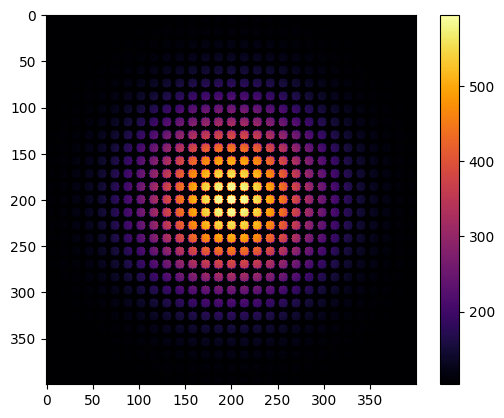

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


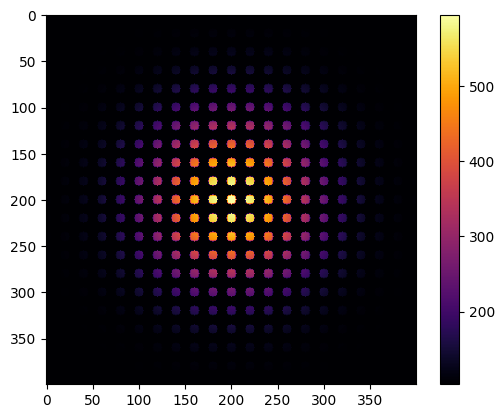

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


In [31]:
# Array to save data
temp_array = [] # Array to save the temperature decay
frames_array = [] # array to save images of the grid

fill_factor_array = [4,10]
frames_name = ["0.8_mu","2_mu"]
number_of_time_steps = 10

for i in range(len(fill_factor_array)):
        
        #Make mesh grid
        startingTemperature = 103.15 # Round about -170C°
        gamma = 0.245 # Gamma value
        B_i = 0.18 # in Delta_x order of magnitude

        timeStep = 7.85 * 10**(-4) # Time step
        boundaryTemp = np.float64(103.15) # temp. at the boundary. is equal to the starting temperature
        Temp_value_to_add = 492.2

        hole_distance = fill_factor_array[i] + 10 # also the diameter of the hole
        resolution = 400
        center= (200, 200) # Center of the simulation
        radius_laser = 15*5 # radius of the laser
        radius_hole = 5 # radius to analyse the heat decay
        fwhm_x = 30 * 5
        fwhm_y = 30 * 5

        # Creating the grids for the simulation
        x1 = np.full(resolution, startingTemperature)
        y1 = np.full(resolution, startingTemperature)

        x2 = np.full(resolution, gamma)
        y2 = np.full(resolution, gamma)

        gridX, gridY = np.meshgrid(x1,y1)
        gridX2, gridY2 = np.meshgrid(x2,y2)

        fullGridX = np.dstack([gridX,gridX2])
        #fullGridY = np.dstack([gridY,gridY2]) Because of symmetry not necessary

        # Calculate in which interval one creates the mask
        # For the left side
        counter = 1
        x= hole_distance
        result_left = resolution-x
        while result_left >=0:
                x += hole_distance
                result_left = center[0]-x
                counter+=1
       
        # For the right side
        counter = 1 
        x= hole_distance
        result_right = resolution+x
        while result_right <= resolution:
                x += hole_distance
                result_right = center[0]+x
                counter+=1
        
        # Creating the mask to know how to add heat
        x_coordinates = np.arange(result_left, result_right, hole_distance) # X-Coordinates of the holes in the gold grid
        y_coordinates = np.arange(result_left, result_right, hole_distance) # Y-Coordinates of the holes in the gold grid
        quadratic_array = np.array([[x, y] for x in x_coordinates for y in y_coordinates]) # combine the coordinates

        mask_spots = np.zeros((resolution,resolution), dtype=bool) # create mask arrays
        Y, X = np.ogrid[:resolution, :resolution] # create the mask grid

        # Mask for the gold holes
        for coord in quadratic_array:
                mask1 = (X-coord[0])**2 + (Y-coord[1])**2 <= radius_hole**2
                mask_spots = mask_spots | mask1
        
        # Mask for the laser beam
        temp_added_fullGridX = heat_entry(fullGridX, mask_spots, resolution, Temp_value_to_add, fwhm_x, fwhm_y) # Add heat to the mask

        # Plot Temperature
        plt.imshow(temp_added_fullGridX[:,:,0], cmap = "inferno")
        plt.colorbar()
        plt.show()

        #Run the simulation
        #Save Initial values of the simulation
        frames = [temp_added_fullGridX[:,:,0].copy()]
        temp_array_initial = [calculateAverageTemperatureWithinCircle(temp_added_fullGridX, center, radius_hole)]

        for t in tqdm(range(0,number_of_time_steps)):
                
                temp_added_fullGridX = heatTransfer(temp_added_fullGridX,boundaryTemp, B_i) # Update the grid
                frames.append(temp_added_fullGridX[:,:,0].copy()) # safe the frame as numpy array

                # Calculate the average temperature within the circle and append to the list
                average_temp_in_circle = calculateAverageTemperatureWithinCircle(temp_added_fullGridX, center, radius_hole)
                temp_array_initial.append(average_temp_in_circle)
        
        # Save simulated data   
        np.save(frames_name[i]+'_gold_fill_heating_array.npy', temp_array_initial)
        np.save(frames_name[i]+'_gold_fill_heating_frames.npy', frames)
        

# Calculate the time_steps
specific_point = timeStep*number_of_time_steps
step_size = timeStep
time_step_array =  np.arange(0, specific_point + step_size, step_size)
time_step_array = [element * 100 for element in time_step_array] # times 100 to transform it into nano seconds (10^-9 *100 = 10^-7)
np.save('fill_time_steps.npy', time_step_array)

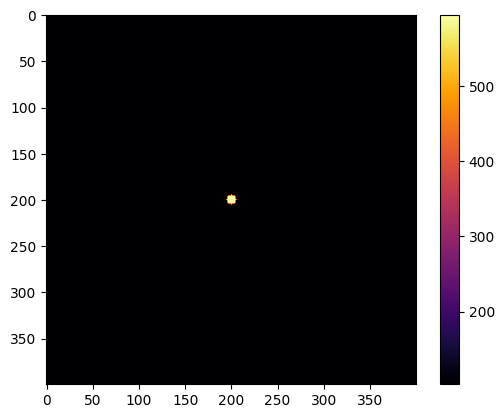

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


In [39]:
# Array to save data
temp_array = [] # Array to save the temperature decay
frames_array = [] # array to save images of the grid
number_of_time_steps = 10

#Make mesh grid
startingTemperature = 103.15 # Round about -170C°
gamma = 0.245 # Gamma value
B_i = 0.18 # in Delta_x order of magnitude

timeStep = 7.85 * 10**(-4) # Time step
boundaryTemp = np.float64(103.15) # temp. at the boundary. is equal to the starting temperature
Temp_value_to_add = 492.2

hole_distance = fill_factor_array[i] + 10 # also the diameter of the hole
resolution = 400
center= (200, 200) # Center of the simulation
radius_hole = 5 # radius to analyse the heat decay
fwhm_x = 30 * 5
fwhm_y = 30 * 5


# Creating the grids for the simulation
x1 = np.full(resolution, startingTemperature)
y1 = np.full(resolution, startingTemperature)

x2 = np.full(resolution, gamma)
y2 = np.full(resolution, gamma)

gridX, gridY = np.meshgrid(x1,y1)
gridX2, gridY2 = np.meshgrid(x2,y2)

fullGridX = np.dstack([gridX,gridX2])
#fullGridY = np.dstack([gridY,gridY2]) Because of symmetry not necessary

# create meshgrid coordinates
x = np.arange(resolution)
y = np.arange(resolution)
# create meshgrid for the x,y coordinates
X, Y = np.meshgrid(x, y)
# Berechne den Abstand jedes Gitterpunkts zum Mittelpunkt
distances = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
# Überprüfe, ob der Abstand kleiner oder gleich dem Radius ist
mask = distances <= radius_hole

# Mask for the laser beam
temp_added_fullGridX = heat_entry(fullGridX, mask, resolution, Temp_value_to_add, fwhm_x, fwhm_y) # Add heat to the mask

# Plot Temperature
plt.imshow(temp_added_fullGridX[:,:,0], cmap = "inferno")
plt.colorbar()
plt.show()


#Run the simulation
#Save Initial values of the simulation
frames = [temp_added_fullGridX[:,:,0].copy()]
temp_array_initial = [calculateAverageTemperatureWithinCircle(temp_added_fullGridX, center, radius_hole)]

for t in tqdm(range(0,number_of_time_steps)):
        
        temp_added_fullGridX = heatTransfer(temp_added_fullGridX,boundaryTemp, B_i) # Update the grid
        frames.append(temp_added_fullGridX[:,:,0].copy()) # safe the frame as numpy array

        # Calculate the average temperature within the circle and append to the list
        average_temp_in_circle = calculateAverageTemperatureWithinCircle(temp_added_fullGridX, center, radius_hole)
        temp_array_initial.append(average_temp_in_circle)

# Save simulated data   
np.save('gold_single_hole_fill_heating_array.npy', temp_array_initial)
np.save('gold_single_hole_fill_heating_frames.npy', frames)


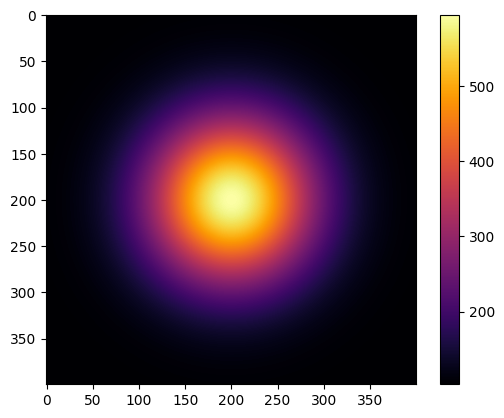

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


In [41]:
# Array to save data
temp_array = [] # Array to save the temperature decay
frames_array = [] # array to save images of the grid
number_of_time_steps = 10

#Make mesh grid
startingTemperature = 103.15 # Round about -170C°
gamma = 0.245 # Gamma value
B_i = 0.18 # in Delta_x order of magnitude

timeStep = 7.85 * 10**(-4) # Time step
boundaryTemp = np.float64(103.15) # temp. at the boundary. is equal to the starting temperature
Temp_value_to_add = 492.2

hole_distance = fill_factor_array[i] + 10 # also the diameter of the hole
resolution = 400
center= (200, 200) # Center of the simulation
radius_hole = 5 # radius to analyse the heat decay
fwhm_x = 30 * 5
fwhm_y = 30 * 5

# Creating the grids for the simulation
x1 = np.full(resolution, startingTemperature)
y1 = np.full(resolution, startingTemperature)

x2 = np.full(resolution, gamma)
y2 = np.full(resolution, gamma)

gridX, gridY = np.meshgrid(x1,y1)
gridX2, gridY2 = np.meshgrid(x2,y2)

fullGridX = np.dstack([gridX,gridX2])
#fullGridY = np.dstack([gridY,gridY2]) Because of symmetry not necessary

mask = np.ones((resolution,resolution), dtype=bool)

# Mask for the laser beam
temp_added_fullGridX = heat_entry(fullGridX, mask, resolution, Temp_value_to_add, fwhm_x, fwhm_y) # Add heat to the mask

# Plot Temperature
plt.imshow(temp_added_fullGridX[:,:,0], cmap = "inferno")
plt.colorbar()
plt.show()


#Run the simulation
#Save Initial values of the simulation
frames = [temp_added_fullGridX[:,:,0].copy()]
temp_array_initial = [calculateAverageTemperatureWithinCircle(temp_added_fullGridX, center, radius_hole)]

for t in tqdm(range(0,number_of_time_steps)):
        
        temp_added_fullGridX = heatTransfer(temp_added_fullGridX,boundaryTemp, B_i) # Update the grid
        frames.append(temp_added_fullGridX[:,:,0].copy()) # safe the frame as numpy array

        # Calculate the average temperature within the circle and append to the list
        average_temp_in_circle = calculateAverageTemperatureWithinCircle(temp_added_fullGridX, center, radius_hole)
        temp_array_initial.append(average_temp_in_circle)

# Save simulated data   
np.save('no_gold_fill_heating_array.npy', temp_array_initial)
np.save('no_gold_fill_heating_frames.npy', frames)

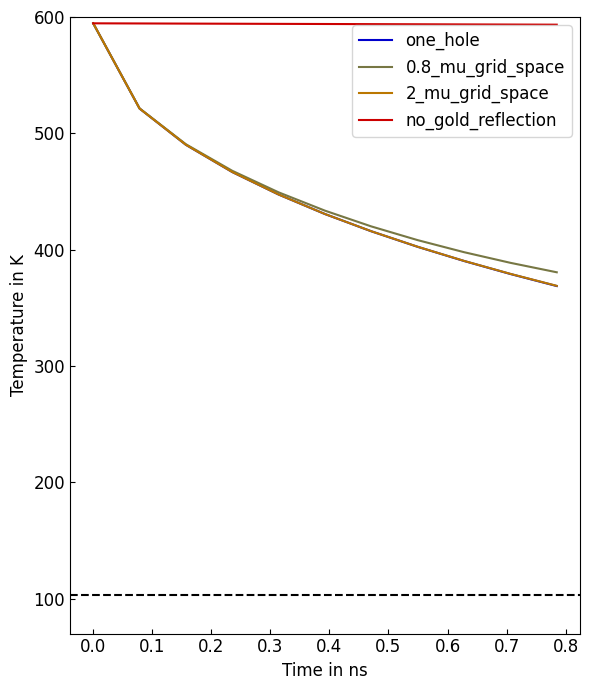

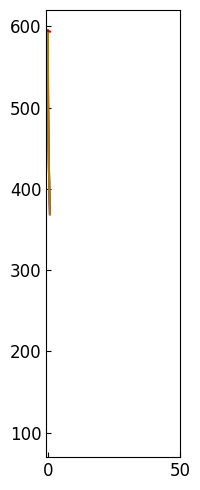

In [43]:
###.............................Plot the data.............................###

# Define the colors for the colormap: shade of blue (0, 0, 0.8), shade of yellow (0.7, 0.7, 0), shade of red (0.8, 0, 0)
colors = [(0, 0, 0.8), (0.7, 0.7, 0), (0.8, 0, 0)]

# Number of colors in the colormap
n_colors = 4

# Create the colormap
blue_yellow_red_cmap = LinearSegmentedColormap.from_list("red_purpel_blue", colors, N=n_colors)

# Create an array of colors from red to blue via purple
color_array = blue_yellow_red_cmap(np.linspace(0, 1, n_colors))

# Load the data
time_step_array = np.load("fill_time_steps.npy")
temp_array = []
temp_array.append(np.load('gold_single_hole_fill_heating_array.npy'))
temp_array.append(np.load('0.8_mu_gold_fill_heating_array.npy'))
temp_array.append(np.load('2_mu_gold_fill_heating_array.npy'))
temp_array.append(np.load('no_gold_fill_heating_array.npy'))


### Plot the Result
plt.figure(figsize=(6,7))
plt.minorticks_on
plt.xlabel(r'Time in ns', fontsize="12")
plt.ylabel(r"Temperature in K", fontsize="12")
label_arr = ['one_hole', '0.8_mu_grid_space', '2_mu_grid_space', 'no_gold_reflection']


for i in range(len(temp_array)):
    plt.plot(time_step_array, temp_array[i], color= color_array[i])

# Show line where the CDW Spots arge gone
plt.axhline(y=103.15, color='black', linestyle='--', label='origin temperature')
plt.ylim(70, 600)
plt.legend(label_arr, loc="upper right", bbox_to_anchor = (1.0,1.0), fontsize=12)

#Set the ricks direction inwards
plt.tick_params(axis='both', which='major', direction='in')
plt.tick_params(axis='both', which='minor', direction='in')

#plt.yscale('log')

plt.tick_params(axis='both', labelsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
#plt.savefig("fill_factor.pdf")
plt.show()

# Plot an enlargement
[100,79,56,42,31,25,20,7,5,2,0]
# Plot the Result
plt.figure(figsize=(2,5))
plt.minorticks_on

for i in range(len(temp_array)):
    #print(i)
    plt.plot(time_step_array, temp_array[i], color= color_array[i])

# Show line where the CDW Spots arge gone
plt.ylim(70, 620)
plt.xlim(-0.5,50)
#Set the ricks direction inwards
plt.tick_params(axis='both', which='major', direction='in')
plt.tick_params(axis='both', which='minor', direction='in')

plt.tick_params(axis='both', labelsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
#plt.savefig("zoom_fill_factor.pdf")
plt.show()

In [38]:
# Use the frames and make a GIF
gif_name = ["0.8","2"]  # Fill_space in micrometer + 100% fill
time_step_array = np.load('fill_time_steps.npy')
frames_array_08 = np.load('0.8_mu_gold_fill_heating_frames.npy')
frames_array_2 = np.load('2_mu_gold_fill_heating_frames.npy')

makeGif(frames_array_08, gif_name[0], time_step_array, 103.15,500, gif_name[0])
makeGif(frames_array_2, gif_name[1], time_step_array, 103.15,500, gif_name[1])


  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


In [40]:
# GIF for gold single holw
time_step_array = np.load('fill_time_steps.npy')
frames_array = np.load('gold_single_hole_fill_heating_frames.npy')

makeGif(frames_array, "single_hole_gold", time_step_array, 103.15,500, "single_hole_gold")

100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


In [42]:
# GIF for no gold mask
time_step_array = np.load('fill_time_steps.npy')
frames_array = np.load('no_gold_fill_heating_frames.npy')

makeGif(frames_array, "no_mask_gold", time_step_array, 103.15,500, "no_mask_gold")

100%|██████████| 11/11 [00:05<00:00,  1.98it/s]
